# Run a Watershed

This Notebook covers running a calibrated NEWT model for a selected watershed.

In [47]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import dataretrieval.nwis as nwis
import pynldas2 as nldas
import s3fs
import zarr
import xarray as xr
import rioxarray as rio
import cartopy.crs as ccrs
import metpy
from pynhd import NLDI
from NEWT import Watershed, perf_summary, NextBmi

In [55]:
sagehen = "10343500"
eagle = "394220106431500"
ws = eagle
raw = pd.read_csv(r"X:\Rio.Data\StreamTemperature\NEXT\ReadyData\daymet_aoi\USGS-" + f"{ws}.csv")
raw["date"] = pd.to_datetime(raw["datetime"]).dt.date
raw = raw.set_index(["date", "variable"])["mean"].unstack(1)[["tmax"]]
raw

variable,tmax
date,
2000-01-01,-0.019951
2000-01-02,-4.205901
2000-01-03,-11.978100
2000-01-04,-2.703965
2000-01-05,-7.595484
...,...
2022-12-27,4.154530
2022-12-28,0.119703
2022-12-29,-7.772742


In [56]:
stdat = nwis.get_dv(sites=[ws], start="2000-01-01", end="2022-12-31", parameterCd="00010")[0].assign(date=lambda x: x.index.date)[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).set_index("date").dropna()
stdat

,temperature
date,
2006-04-29,5.5
2006-04-30,6.3
2006-05-01,7.3
2006-05-02,7.8
2006-05-03,7.8
...,...
2022-12-27,0.0
2022-12-28,0.0
2022-12-29,0.0


In [57]:
# Optional: add streamflow
qdat = nwis.get_dv(sites=[ws], start="2000-01-01", end="2022-12-31", parameterCd="00060")[0].assign(date=lambda x: x.index.date)[["date", "00060_Mean"]].rename(columns={"00060_Mean": "Q"}).set_index("date").dropna()
qdat

,Q
date,
2006-04-29,1000.0
2006-04-30,901.0
2006-05-01,941.0
2006-05-02,1000.0
2006-05-03,1140.0
...,...
2022-12-27,91.6
2022-12-28,89.7
2022-12-29,88.3


In [58]:
data = stdat.merge(raw, on="date").merge(qdat, on="date")
data["date"] = pd.to_datetime(data.index).normalize()
data.index = range(len(data))
data

,temperature,tmax,Q,date
0,5.5,7.180149,1000.0,2006-04-29
1,6.3,9.414374,901.0,2006-04-30
2,7.3,11.726849,941.0,2006-05-01
3,7.8,13.545753,1000.0,2006-05-02
4,7.8,11.731435,1140.0,2006-05-03
...,...,...,...,...
6048,0.0,4.154530,91.6,2022-12-27
6049,0.0,0.119703,89.7,2022-12-28
6050,0.0,-7.772742,88.3,2022-12-29
6051,0.0,-4.506784,88.8,2022-12-30


In [59]:
cut = round(len(data) * 0.7)
cal = data.iloc[:cut,:].copy()
val = data.iloc[cut:,:].copy()
print(f"Cal: {min(cal['date'].dt.date)} - {max(cal['date'].dt.date)} | Val: {min(val['date'].dt.date)} - {max(val['date'].dt.date)}")

Cal: 2006-04-29 - 2018-01-09 | Val: 2018-01-10 - 2022-12-31


In [60]:
model = Watershed.from_data(cal)

In [61]:
pred = model.run_series(val)

In [62]:
perf_summary(pred)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.937599,1.521532,0.935208,-0.562276,-0.04006,3.522854


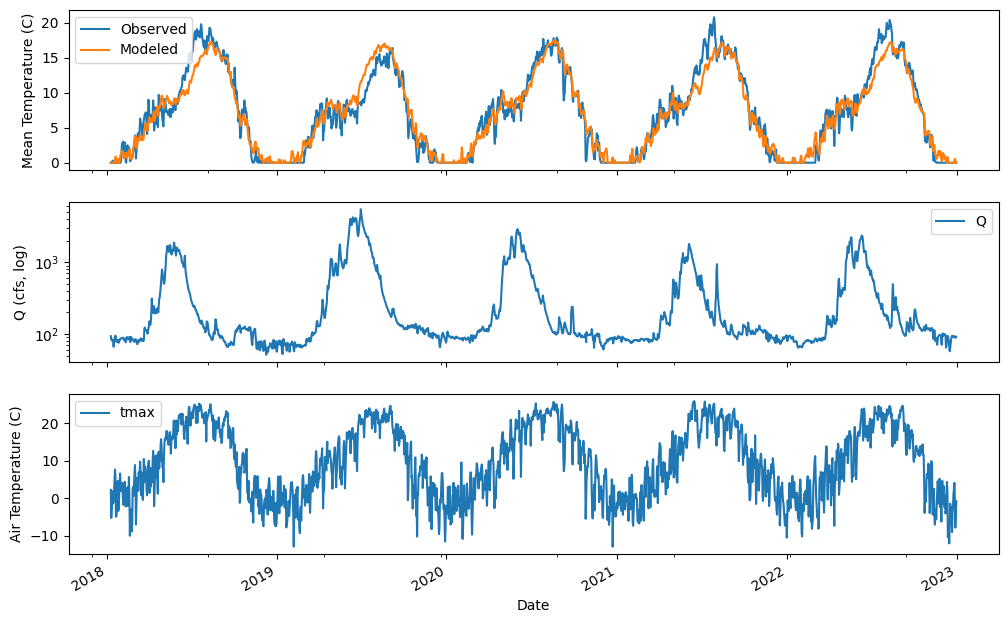

In [63]:
# fig = plt.figure(figsize=(12, 8))
# ax = plt.axes()
fig, axes = plt.subplots(3, 1, figsize=(12,8), sharex=True)
ax = axes[0]
pred.plot(x="date", y="temperature", label="Observed", ax=ax)
pred.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
# ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
# _ = ax.set_title("Eagle River")
pred.plot(x="date", y="Q", ax=axes[1], logy=True)
axes[1].set_ylabel("Q (cfs, log)")
pred.plot(x="date", y="tmax", ax=axes[2])
axes[2].set_ylabel("Air Temperature (C)")
axes[-1].set_xlabel("Date")
fig.savefig("results/EagleCalibrated.png")

## BMI Version

Let's try this with the BMI.  We'll export the calibrated model above, then use it to run the validation period.

It works!  Awesome.

In [11]:
file = f"model{ws}.yaml"
model.date = val["date"].iloc[0]
model.to_file(file)  # Note: with numpy arrays and stuff, the serialization is bizarre but it works

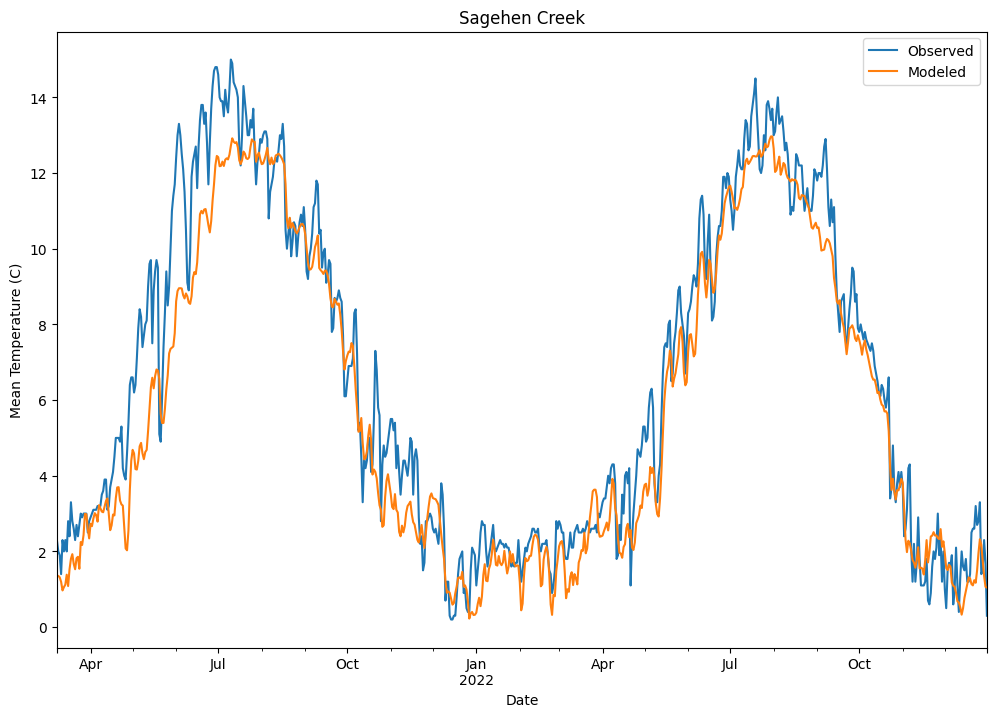

In [12]:
# First, make sure file I/O works
mod2 = Watershed.from_file(file)
pred = mod2.run_series(val)
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
pred.plot(x="date", y="temperature", label="Observed", ax=ax)
pred.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
_ = ax.set_title("Sagehen Creek")

In [13]:
# Now, do it with BMI.
bmi = NextBmi()
bmi.initialize(file)

In [14]:
bmi._model.date

Timestamp('2021-03-08 00:00:00')

In [15]:
at = bmi.get_input_var_names()
st = bmi.get_output_var_names()[0]
def runner(mod, row):
    mod.set_value(at, np.array([row.tmax]))
    # mod.set_value(vp, np.array([row.vp]))
    mod.update()
    return mod.get_value(st, np.array([1.0]))[0]

In [16]:
bpr = val.copy()
bpr["temp.mod"] = [runner(bmi, row) for row in bpr.itertuples()]

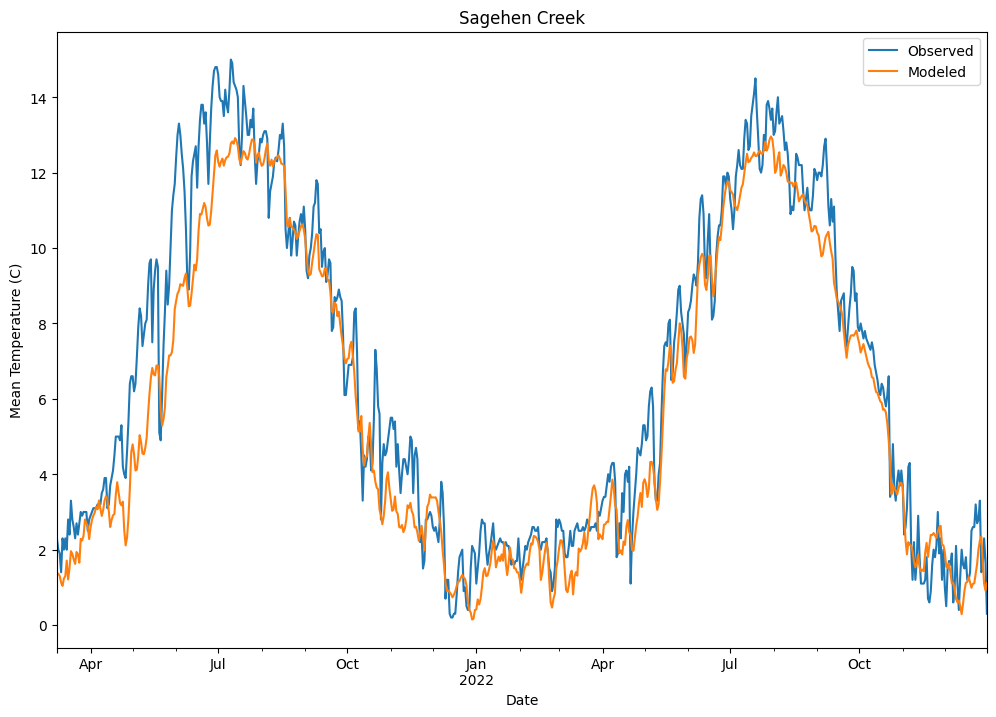

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = plt.axes()
bpr.plot(x="date", y="temperature", label="Observed", ax=ax)
bpr.plot(x="date", y="temp.mod", label="Modeled", ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Mean Temperature (C)")
_ = ax.set_title("Sagehen Creek")

# Near-Real Time

In my use case, daymet data runs through 2022.  After that, switch to using more recent data.  In this test, climatology is *not* adjusted.  We can use NLDAS data to fill in the gaps and get very recent.

In [64]:
nldi = NLDI()
basin = nldi.get_basins(ws)
geo = basin.geometry.iloc[0]

<Axes: >

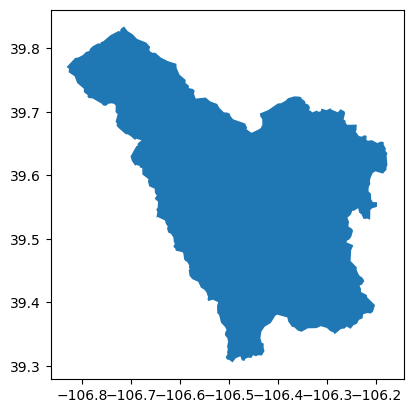

In [65]:
basin.plot()

In [80]:
rt = nldas.get_bygeom(geo, "2023-01-01", "2024-07-20", 4326, variables="temp")

C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\pynldas2\pynldas2.py:497: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(StringIO(txt), skiprows=39, delim_whitespace=True).dropna()
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\pynldas2\pynldas2.py:497: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(StringIO(txt), skiprows=39, delim_whitespace=True).dropna()
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\pynldas2\pynldas2.py:497: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(StringIO(txt), skiprows=39, delim_whitespace=True).dropna()
C:\Users\dphilippus\.conda\envs\next_setup\Lib\site-packages\pynldas2\

In [81]:
rtab = rt.groupby("time").map(lambda x: x.mean()).to_dataframe()
rtab

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_10788\795806793.py:1: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  rtab = rt.groupby("time").map(lambda x: x.mean()).to_dataframe()


,temp,spatial_ref
time,,
2023-01-01 00:00:00,270.841818,0
2023-01-01 01:00:00,270.438636,0
2023-01-01 02:00:00,270.036364,0
2023-01-01 03:00:00,269.632727,0
2023-01-01 04:00:00,269.575000,0
...,...,...
2024-07-20 19:00:00,291.810000,0
2024-07-20 20:00:00,292.398182,0
2024-07-20 21:00:00,292.984545,0


In [82]:
rt_tmax = rtab.assign(date = lambda x: x.index.date).groupby("date")[["temp"]].max().rename(columns={"temp": "tmax"}) - 273.15
rt_tmax

,tmax
date,
2023-01-01,0.240455
2023-01-02,-1.782727
2023-01-03,-6.296364
2023-01-04,-8.384091
2023-01-05,-1.287273
...,...
2024-07-16,19.457727
2024-07-17,19.889545
2024-07-18,20.136364


In [83]:
data_now = nwis.get_dv(sites=[ws], start="2023-01-01", end="2024-07-20", parameterCd="00010")[0].assign(date=lambda x: x.index.date)[["date", "00010_Mean"]].rename(columns={"00010_Mean": "temperature"}).set_index("date").dropna().merge(rt_tmax, on="date")
data_now["date"] = pd.to_datetime(data_now.index)
data_now = pd.concat([val[["temperature", "tmax", "date"]], data_now])
data_now.index = range(len(data_now))
data_now

,temperature,tmax,date
0,-0.0,2.277873,2018-01-10
1,-0.0,-5.206417,2018-01-11
2,0.0,-2.603880,2018-01-12
3,0.1,-0.932367,2018-01-13
4,0.3,1.923767,2018-01-14
...,...,...,...
2378,15.5,19.457727,2024-07-16
2379,15.2,19.889545,2024-07-17
2380,15.7,20.136364,2024-07-18
2381,14.9,19.559091,2024-07-19


In [84]:
prd_now = model.run_series(data_now)

In [85]:
perf_summary(prd_now)

,R2,RMSE,NSE,Pbias,Bias,MaxMiss
0,0.937969,1.468306,0.936582,-1.077893,-0.0751,3.522854


<Axes: xlabel='date'>

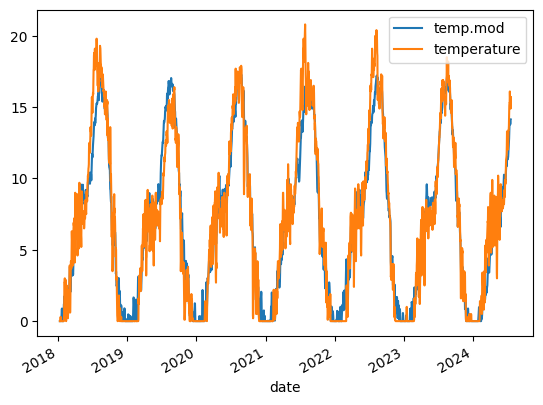

In [86]:
ax = prd_now.plot(x="date", y="temp.mod")
prd_now.plot(x="date", y="temperature", ax=ax)

# Forecast

See: https://mesowest.utah.edu/html/hrrr/zarr_documentation/html/zarr_HowToDownload.html

Wherein we download zarr-format HRRR data and run an actual forecast.  Starting at GMT 0600 means the first 24 hours capture most of the day for all of the CONUS and we can use that for a decent estimate at daily tmax.

## Pull Forecast Data

In [48]:
url_base = "s3://hrrrzarr/"
tmpn = "sfc/20240801/20240801_06z_fcst.zarr/surface/TMP"
group_url = url_base + tmpn
subgroup_url = group_url + "/surface"
fs = s3fs.S3FileSystem(anon=True)
grid = zarr.open(s3fs.S3Map(url_base, s3=fs))["grid/HRRR_chunk_index.zarr"]
ds = xr.open_mfdataset([s3fs.S3Map(u, s3=fs) for u in [group_url, subgroup_url]], engine="zarr")
ds["time"] = (ds["time"] - np.timedelta64(6, 'h')).astype("datetime64[D]")  # approximate, but gets it to the right day-ish

# Direct copy-paste from tutorial link above
projection = ccrs.LambertConformal(central_longitude=262.5, 
                                   central_latitude=38.5, 
                                   standard_parallels=(38.5, 38.5),
                                    globe=ccrs.Globe(semimajor_axis=6371229,
                                                     semiminor_axis=6371229))

ds = ds.rename(projection_x_coordinate="x", projection_y_coordinate="y")
ds = ds.metpy.assign_crs(projection.to_cf())
ds = ds.metpy.assign_latitude_longitude()    
ds

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_10788\621297665.py:8: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds["time"] = (ds["time"] - np.timedelta64(6, 'h')).astype("datetime64[D]")  # approximate, but gets it to the right day-ish


<xarray.Dataset> Size: 213MB
Dimensions:                  (time: 48, y: 1059, x: 1799)
Coordinates:
  * x                        (x) float64 14kB -2.698e+06 ... 2.696e+06
  * y                        (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.587e+06
  * time                     (time) datetime64[ns] 384B 2024-08-01 ... 2024-0...
    metpy_crs                object 8B Projection: lambert_conformal_conic
    latitude                 (y, x) float64 15MB 21.14 21.15 ... 47.85 47.84
    longitude                (y, x) float64 15MB -122.7 -122.7 ... -60.95 -60.92
Data variables:
    TMP                      (time, y, x) float16 183MB dask.array<chunksize=(48, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] 384B dask.array<chunksize=(48,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] 8B ...

In [52]:
tmax = ds["TMP"][:47,:,:].groupby("time").max() - 273.15
tmax

<xarray.DataArray 'TMP' (time: 2, y: 1059, x: 1799)> Size: 8MB
dask.array<sub, shape=(2, 1059, 1799), dtype=float16, chunksize=(1, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * x          (x) float64 14kB -2.698e+06 -2.695e+06 ... 2.693e+06 2.696e+06
  * y          (y) float64 8kB -1.587e+06 -1.584e+06 ... 1.584e+06 1.587e+06
    metpy_crs  object 8B Projection: lambert_conformal_conic
    latitude   (y, x) float64 15MB 21.14 21.15 21.15 21.16 ... 47.86 47.85 47.84
    longitude  (y, x) float64 15MB -122.7 -122.7 -122.7 ... -60.99 -60.95 -60.92
  * time       (time) datetime64[ns] 16B 2024-08-01 2024-08-02

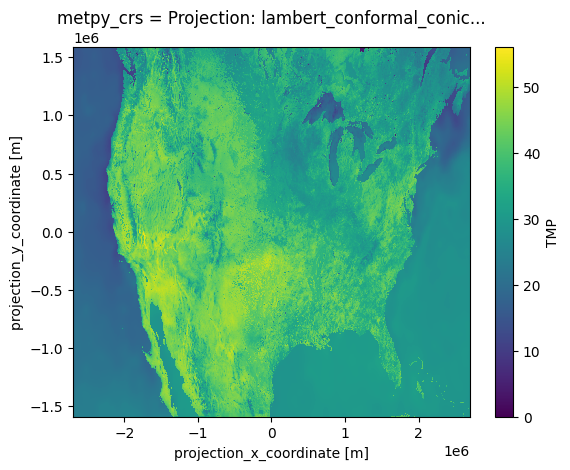

In [53]:
tmax[0,:,:].plot()

## Clip to Watershed

In [70]:
tmax = tmax.rio.write_crs(projection)
clip = tmax.rio.clip(basin.geometry.values, basin.crs)

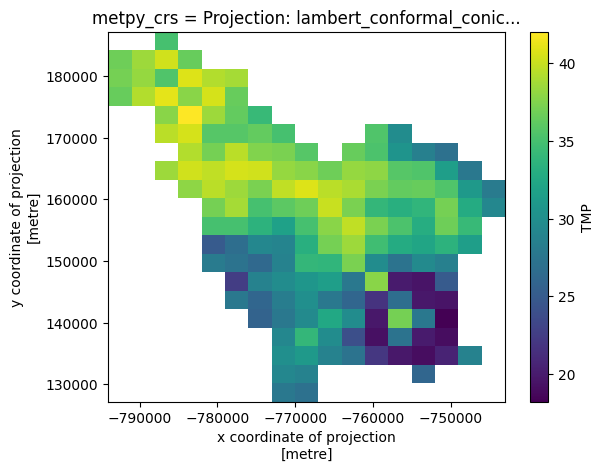

In [72]:
clip[0,:,:].plot()

## Compute Areal Means

In [76]:
temps = clip.groupby("time").map(lambda x: x.mean()).to_pandas().rename("tmax")
temps

C:\Users\dphilippus\AppData\Local\Temp\ipykernel_10788\1808511346.py:1: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  temps = clip.groupby("time").map(lambda x: x.mean()).to_pandas().rename("tmax")


time
2024-08-01    32.65625
2024-08-02    32.87500
Name: tmax, dtype: float16

In [77]:
temps.index

DatetimeIndex(['2024-08-01', '2024-08-02'], dtype='datetime64[ns]', name='time', freq=None)

In [87]:
inputs = pd.concat([data_now[["date", "tmax"]], pd.DataFrame({"date": temps.index, "tmax": temps})])
inputs

,date,tmax
0,2018-01-10,2.277873
1,2018-01-11,-5.206417
2,2018-01-12,-2.603880
3,2018-01-13,-0.932367
4,2018-01-14,1.923767
...,...,...
2380,2024-07-18,20.136364
2381,2024-07-19,19.559091
2382,2024-07-20,19.834545
2024-08-01 00:00:00,2024-08-01,32.656250


There's a few missing days which prevent an actual forecast, but that does give us the basis for building out a forecasting setup.  Now let's go script it up!